<a href="https://colab.research.google.com/github/rakezhjab/Advanced-machine-learning-assessment/blob/main/Site_spec_weed_mgmt_(Resnet50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 34.5 MB/s 


In [ ]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import inception_v3
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import imgaug as ia
import imgaug.augmenters as iaa
from keras.utils import layer_utils
from tensorflow.keras.utils import to_categorical
from statistics import mean
import math
import cv2
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

**Resizing the image and Loading the dataset**

In [ ]:
# re-size all the images
IMAGE_SIZE = [224, 224]
#loading the data
train_dir = r"/content/drive/MyDrive/data_task1/train"
test_dir = r"/content/drive/MyDrive/data_task1/test"
val_dir = r"/content/drive/MyDrive/data_task1/val"

**Visualisation of dataset**

In [ ]:
datasets = [r"/content/drive/MyDrive/data_task1/train"]

Classes = ["blackgrass","charlock","cleavers","fat hen","maize","wheat"]

n_classes = len(Classes)

Classes

['blackgrass', 'charlock', 'cleavers', 'fat hen', 'maize', 'wheat']

**Augmentation process**

In [ ]:
def augmentation_classes(Classes,train_dir):
    size_dict={}
    for i,classes in enumerate(Classes):
         size_dict[Classes[i]]=len(os.listdir(os.path.join(train_dir, classes)))
    print('Sample sizes of different classes are\n\n',size_dict)
    values_list=list(size_dict.values())
    ideal_samples=math.ceil(mean(values_list)*1.1)
    required_aug=[]
    for i,j in enumerate(size_dict):
        if size_dict[j]<ideal_samples:
            required_aug.append(j)
    print('\n\nMinority classes requiring augmentations are\n',required_aug)
    return required_aug,ideal_samples,size_dict

In [ ]:
def image_augmentation(raw_images):
    
    
    seq=iaa.Sequential([iaa.Fliplr(0.5),
                        iaa.Flipud(0.3),
                        iaa.LinearContrast((0.75, 1.5)),
                        iaa.Crop(percent=(0, 0.2)),
                        iaa.Affine(rotate=(-45, 45)),
                        iaa.GaussianBlur(sigma=(0.0, 3.0))
                        ])
    image_aug=seq(images=raw_images)
    return image_aug

In [ ]:
def preprocessing(img_path):
    image = cv2.resize(cv2.imread(img_path), (224,224), interpolation = cv2.INTER_NEAREST)
    return image

In [ ]:
def get_training_data( model):
        
    if model == "resnet50":
        datagen = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input, validation_split=0.15)
    elif model == "inceptionV3":
        datagen = ImageDataGenerator(preprocessing_function = inception_v3.preprocess_input, validation_split=0.15)
    elif model == 'vgg16':
        datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input, validation_split=0.15)

    train_data_den = datagen.flow_from_directory(
            directory= os.path.join(save_dir),
            class_mode = "categorical",
            batch_size=32,
            shuffle=True,
            subset='training'
        )
        
    val_data_gen = datagen.flow_from_directory(
            directory= os.path.join(save_dir),
            class_mode = 'categorical',
            batch_size=32,
            shuffle=False,
            subset='validation'
        )

    return train_data_den, val_data_gen

In [ ]:
def augment_and_store_data(Classes,train_dir,save_dir,required_aug,ideal_samples,size_dict):
    for i,sample_class in enumerate(Classes):
        try:
            os.mkdir(os.path.join(save_dir,sample_class))
        except FileExistsError:
            pass
        img_list=[]
        for img_loc in os.listdir(os.path.join(train_dir,sample_class)):
            image = preprocessing(os.path.join(train_dir, sample_class, img_loc))
            img_list.append(image)
        if sample_class in required_aug:
            aug_img= image_augmentation(img_list)
            req_img=random.sample(aug_img,(ideal_samples-size_dict[sample_class]))
            img_list.extend(req_img)
        for image_number, image in enumerate(img_list):
            cv2.imwrite(os.path.join(save_dir, sample_class, "{}.png".format(image_number + 1)), image)

In [ ]:
def model_prep(model_arch,monitor,lr_patience,early_stop_patience,min_lr):
    checkpoint = ModelCheckpoint(filepath=os.path.join(r'/content/drive/MyDrive/task1 file',model_arch,'.h5'), monitor='val_acc', mode='max', save_best_only=True)
    #reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.2, patience=1, min_lr=min_lr)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=12, verbose=1, mode='min', restore_best_weights=True)
    #CSVLogger logs epoch, acc, loss, val_acc, val_loss
    log_csv = CSVLogger('my_logs.csv', separator=',', append=False)
    callback=[checkpoint,early_stop, log_csv]
    train_gen, val_gen = get_training_data(model = model_arch)
    
    return callback,train_gen,val_gen

**Before Augmentation**

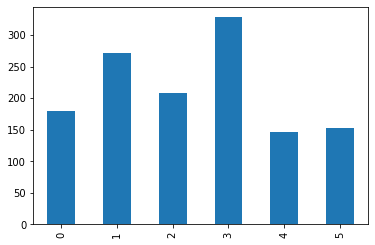

In [ ]:
a={}
for i,classes in enumerate(Classes):
     a[i]=len(os.listdir(os.path.join(train_dir, classes)))
a=pd.DataFrame(a.items(),columns=['index','no.of samples'],index=a.keys())
a['no.of samples'].plot(kind='bar')
sample_size=a['no.of samples']

**Finding the classes needing for the augmentation**

In [ ]:
required_aug,ideal_samples,size_dict = augmentation_classes(Classes,train_dir)

Sample sizes of different classes are

 {'blackgrass': 180, 'charlock': 272, 'cleavers': 208, 'fat hen': 328, 'maize': 146, 'wheat': 153}


Minority classes requiring augmentations are
 ['blackgrass', 'cleavers', 'maize', 'wheat']


**Augmenting and storing data**

In [ ]:
save_dir = r"/content/drive/MyDrive/task1 file"

In [ ]:
augment_and_store_data(Classes,train_dir,save_dir,required_aug,ideal_samples,size_dict)

**After augmentation**

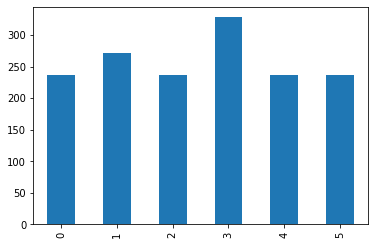

In [ ]:
c={}
for i,classes in enumerate(Classes):
     c[i]=len(os.listdir(os.path.join(save_dir, classes)))
c=pd.DataFrame(c.items(),columns=['index','no.of samples'],index=c.keys())
c['no.of samples'].plot(kind='bar')
sample_size=a['no.of samples']

**Model Training**

In [ ]:
from tensorflow.keras.callbacks import CSVLogger

In [ ]:
callback,train_gen,val_gen=model_prep('inceptionV3','val_loss',2,5,0.000001)

Found 1315 images belonging to 6 classes.
Found 229 images belonging to 6 classes.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
# useful for getting number of classes
folders = glob(r"/content/drive/MyDrive/data_task1/train/*")

In [ ]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.models import Model

resnet50_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
x = resnet50_model.output
x = Flatten()(x)
#x = Dense(128,activation = "relu")(x)
#x = Dropout(0.5)(x)
pred = Dense(6,activation = "softmax")(x)
model = Model(inputs = resnet50_model.input,outputs = pred)

for layers in resnet50_model.layers:
    layers.trainable = True

model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
history = model.fit_generator(
  train_gen,
  validation_data=val_gen,
  epochs=50,
  steps_per_epoch=len(train_gen),
  validation_steps=len(val_gen),
callbacks= callback)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


42/42 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.7962

42/42 [==============================] - 29s 496ms/step - loss: 0.5568 - accuracy: 0.7962 - val_loss: 2.5160 - val_accuracy: 0.5371
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9810

42/42 [==============================] - 19s 439ms/step - loss: 0.0712 - accuracy: 0.9810 - val_loss: 0.5062 - val_accuracy: 0.9083
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9962

42/42 [==============================] - 19s 442ms/step - loss: 0.0218 - accuracy: 0.9962 - val_loss: 0.2808 - val_accuracy: 0.9214
Epoch 4/50
42/42 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9924

42/42 [==============================] - 19s 450ms/step - loss: 0.0242 - accuracy: 0.9924 - val_loss: 0.1423 - val_accuracy: 0.9520
Epoch 5/50
42/42 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 0.9901

42/42 [==============================] - 19s 468ms/step - loss: 0.0264 - accuracy: 0.9901 - val_loss: 0.1459 - val_accuracy: 0.9607
Epoch 6/50
42/42 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9901

42/42 [==============================] - 20s 476ms/step - loss: 0.0266 - accuracy: 0.9901 - val_loss: 0.1148 - val_accuracy: 0.9694
Epoch 7/50
42/42 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9962

42/42 [==============================] - 20s 470ms/step - loss: 0.0145 - accuracy: 0.9962 - val_loss: 0.1217 - val_accuracy: 0.9694
Epoch 8/50
42/42 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9992

42/42 [==============================] - 20s 472ms/step - loss: 0.0072 - accuracy: 0.9992 - val_loss: 0.1133 - val_accuracy: 0.9738
Epoch 9/50
42/42 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

42/42 [==============================] - 20s 466ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0937 - val_accuracy: 0.9782
Epoch 10/50
42/42 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

42/42 [==============================] - 20s 471ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0907 - val_accuracy: 0.9738
Epoch 11/50
42/42 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

42/42 [==============================] - 20s 469ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1245 - val_accuracy: 0.9694
Epoch 12/50
42/42 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

42/42 [==============================] - 20s 466ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1163 - val_accuracy: 0.9651
Epoch 13/50
42/42 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9977

42/42 [==============================] - 20s 464ms/step - loss: 0.0122 - accuracy: 0.9977 - val_loss: 0.2626 - val_accuracy: 0.9301
Epoch 14/50
42/42 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9726

42/42 [==============================] - 20s 468ms/step - loss: 0.0894 - accuracy: 0.9726 - val_loss: 0.7185 - val_accuracy: 0.8122
Epoch 15/50
42/42 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9772

42/42 [==============================] - 20s 467ms/step - loss: 0.0695 - accuracy: 0.9772 - val_loss: 0.2218 - val_accuracy: 0.9389
Epoch 16/50
42/42 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9901

42/42 [==============================] - 20s 468ms/step - loss: 0.0305 - accuracy: 0.9901 - val_loss: 0.2646 - val_accuracy: 0.9301
Epoch 17/50
42/42 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9932

42/42 [==============================] - 20s 475ms/step - loss: 0.0296 - accuracy: 0.9932 - val_loss: 0.9066 - val_accuracy: 0.8777
Epoch 18/50
42/42 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9688

42/42 [==============================] - 20s 464ms/step - loss: 0.1244 - accuracy: 0.9688 - val_loss: 0.9406 - val_accuracy: 0.8603
Epoch 19/50
42/42 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9939

42/42 [==============================] - 20s 464ms/step - loss: 0.0393 - accuracy: 0.9939 - val_loss: 0.5617 - val_accuracy: 0.8952
Epoch 20/50
42/42 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9954

42/42 [==============================] - 20s 466ms/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.1113 - val_accuracy: 0.9694
Epoch 21/50
42/42 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9992

42/42 [==============================] - 20s 466ms/step - loss: 0.0058 - accuracy: 0.9992 - val_loss: 0.1253 - val_accuracy: 0.9651
Epoch 22/50
42/42 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 10.
42/42 [==============================] - 20s 470ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1225 - val_accuracy: 0.9651
Epoch 22: early stopping


In [ ]:
model.save('/content/drive/MyDrive/save file task 1/Resnet50_models.hdf5')

Values stored in history are ... 
 {'loss': [0.5568490028381348, 0.07117000967264175, 0.02179473452270031, 0.02420283481478691, 0.02636825293302536, 0.026615111157298088, 0.014490111730992794, 0.007195890415459871, 0.0021005976013839245, 0.0017184973694384098, 0.001835295814089477, 0.0024838692042976618, 0.012189224362373352, 0.08940066397190094, 0.06945862621068954, 0.03049570508301258, 0.029557641595602036, 0.12439341098070145, 0.039317160844802856, 0.015503534115850925, 0.005829854402691126, 0.0023294929414987564], 'accuracy': [0.7961977124214172, 0.980988621711731, 0.9961977005004883, 0.9923954606056213, 0.9901140928268433, 0.9901140928268433, 0.9961977005004883, 0.9992395639419556, 1.0, 1.0, 1.0, 1.0, 0.9977186322212219, 0.9726235866546631, 0.9771863222122192, 0.9901140928268433, 0.9931558966636658, 0.9688212871551514, 0.9939163327217102, 0.9954372644424438, 0.9992395639419556, 1.0], 'val_loss': [2.5160117149353027, 0.5062065124511719, 0.2808208167552948, 0.1422768533229828, 0.145

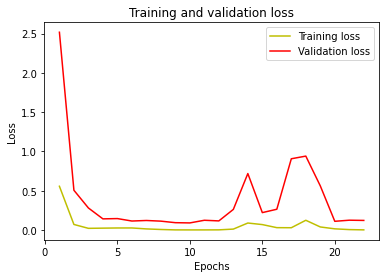

In [84]:
#plot the training and validation accuracy and loss at each epoch
print("Values stored in history are ... \n", history.history)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Values stored in history are ... 
 {'loss': [0.5568490028381348, 0.07117000967264175, 0.02179473452270031, 0.02420283481478691, 0.02636825293302536, 0.026615111157298088, 0.014490111730992794, 0.007195890415459871, 0.0021005976013839245, 0.0017184973694384098, 0.001835295814089477, 0.0024838692042976618, 0.012189224362373352, 0.08940066397190094, 0.06945862621068954, 0.03049570508301258, 0.029557641595602036, 0.12439341098070145, 0.039317160844802856, 0.015503534115850925, 0.005829854402691126, 0.0023294929414987564], 'accuracy': [0.7961977124214172, 0.980988621711731, 0.9961977005004883, 0.9923954606056213, 0.9901140928268433, 0.9901140928268433, 0.9961977005004883, 0.9992395639419556, 1.0, 1.0, 1.0, 1.0, 0.9977186322212219, 0.9726235866546631, 0.9771863222122192, 0.9901140928268433, 0.9931558966636658, 0.9688212871551514, 0.9939163327217102, 0.9954372644424438, 0.9992395639419556, 1.0], 'val_loss': [2.5160117149353027, 0.5062065124511719, 0.2808208167552948, 0.1422768533229828, 0.145

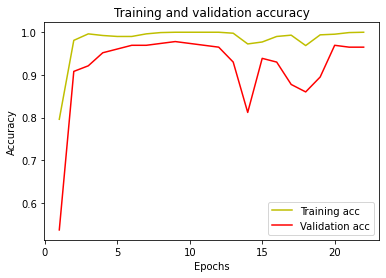

In [85]:
#plot the training and validation accuracy and loss at each epoch
print("Values stored in history are ... \n", history.history)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Confusion matrix and prediction**

In [86]:
resnet50_model = keras.models.load_model('/content/drive/MyDrive/save file task 1/Resnet50_models.hdf5')

In [87]:
callback,train_gen,val_gen=model_prep('resnet50','val_loss',2,5,0.000001)
model.evaluate_generator(generator=val_gen)

Found 1315 images belonging to 6 classes.
Found 229 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.09070271998643875, 0.9737991094589233]

In [88]:
predictions = model.predict_generator(val_gen,28)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Classification Report
              precision    recall  f1-score   support

  blackgrass       0.94      0.94      0.94        35
    charlock       1.00      1.00      1.00        40
    cleavers       1.00      1.00      1.00        35
     fat hen       0.98      0.98      0.98        49
       maize       1.00      0.94      0.97        35
       wheat       0.92      0.97      0.94        35

    accuracy                           0.97       229
   macro avg       0.97      0.97      0.97       229
weighted avg       0.97      0.97      0.97       229



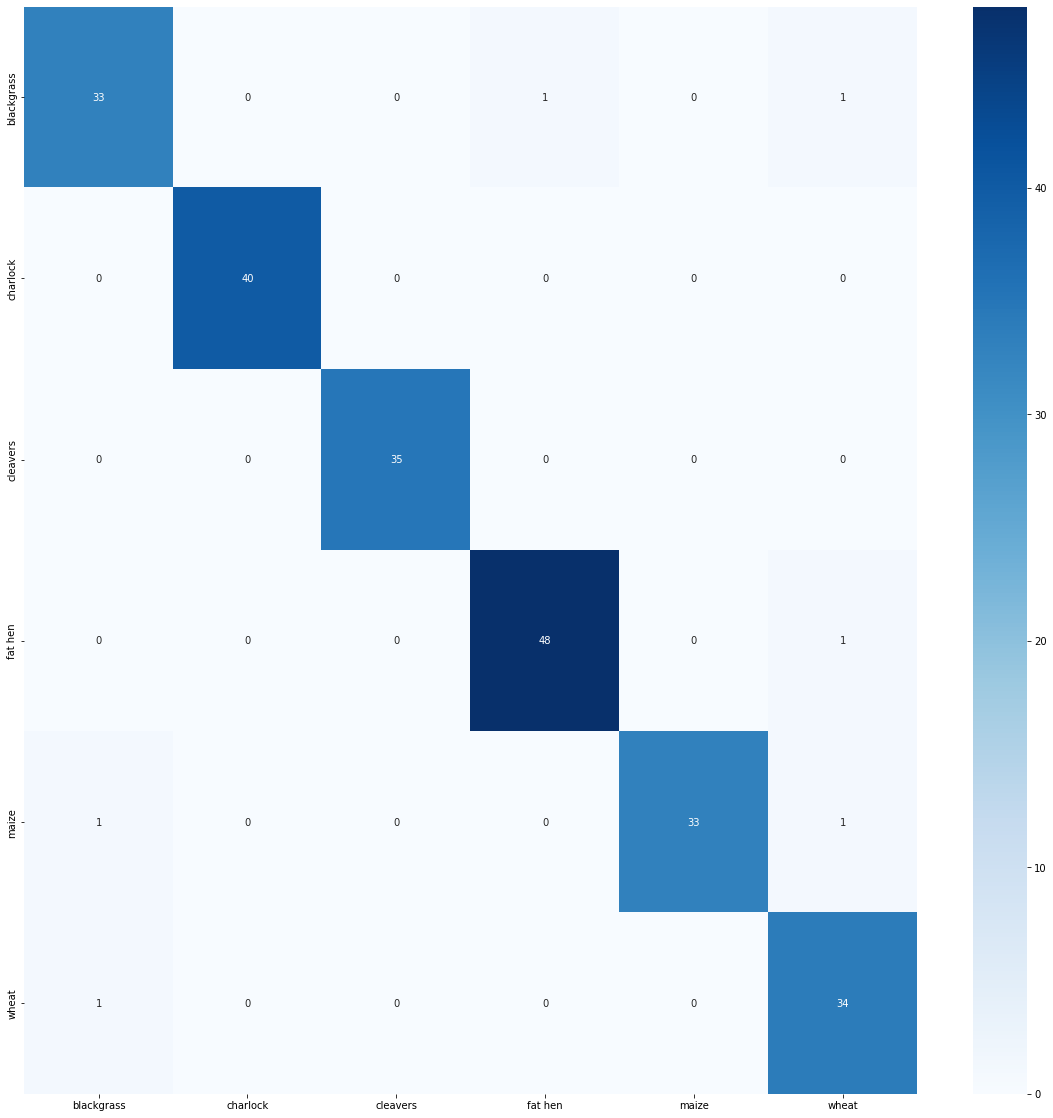

In [89]:
y_pred = np.argmax(predictions, axis=1)
cf_matrix = confusion_matrix(val_gen.classes, y_pred)
print('Classification Report')
print(classification_report(val_gen.classes, y_pred, target_names=Classes))
plt.figure(figsize=(20,20))
sns.heatmap(cf_matrix, annot=True, xticklabels=Classes, yticklabels=Classes, cmap='Blues')